In [1]:
import torch
import torch.nn as nn
import matplotlib.pyplot as plt
from torch.utils.data import Dataset,DataLoader
import torchvision.transforms as transforms
from  torchvision.datasets import ImageFolder
from torch.autograd import Variable
import cv2
import numpy as np
import os, random,sys


# Build an Autoencoder for a human face dataset

We will use a dataset containig images of people and train an autoencoder on it.

## Step 1

Download and unzip the ``lfw.zip`` file . Adjust the ``path`` variable so that it contains the address of the unzipped folder. We will create a dataloader from this folder.


In [2]:
!pip install patool
import patoolib
patoolib.extract_archive('/content/sample_data/lfw.zip',outdir='/content/sample_data')

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 93.7/93.7 kB 2.2 MB/s eta 0:00:00


INFO patool: Extracting /content/sample_data/lfw.zip ...
INFO:patool:Extracting /content/sample_data/lfw.zip ...
INFO patool: running /usr/bin/7z x -o/content/sample_data -- /content/sample_data/lfw.zip
INFO:patool:running /usr/bin/7z x -o/content/sample_data -- /content/sample_data/lfw.zip
INFO patool:     with input=''
INFO:patool:    with input=''
INFO patool: ... /content/sample_data/lfw.zip extracted to `/content/sample_data'.
INFO:patool:... /content/sample_data/lfw.zip extracted to `/content/sample_data'.


'/content/sample_data'

In [3]:
# !unzip '/content/sample_data/lfw.zip'
path = '/content/sample_data/lfw'

In [4]:
transform    = transforms.Compose([transforms.ToTensor()])
dataloader = DataLoader(ImageFolder(path, transform,),batch_size=32, shuffle=True)


This project is compute intensive. If you have a cuda or mps device on your laptop make sure you use that in the training.

In [5]:
if torch.backends.mps.is_available():
    device = torch.device("mps")
else:
    print ("MPS device not found.")


MPS device not found.


## Step 2
Each datapoint is an image. Get a sample of the data and print its dimensions and explain what each dimension means.

torch.Size([32, 3, 250, 250])
torch.Size([250, 250, 3])


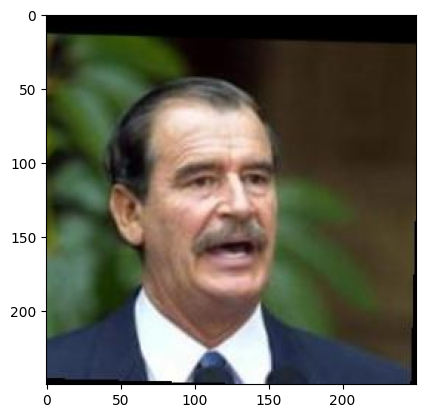

In [6]:
for x,y in dataloader:
    print(x.shape)
    x = x[0].permute(1, 2, 0)
    print(x.shape)
    # print(y)
    plt.imshow(x)
    break

torch.Size([250, 250, 3]) represents the dimensions of the first image taken
from the dataloader.
*   First dimension represents the height of the image
*   Second dimension represnts the width of the image
*   Third dimension represents the channels of the image. In this case, it is 3 which represents it's an RGB image.






# Step 3

Create a new pytorch model calss for your autoencoder. You can use Conv2d, MaxPool2d, BatchNorm2d, ConvTranspose2d and Linear Layers as as well as activation functions. Optionally, you can use UpSample, AveragePool2d and Interpolate2d as well.

**Create seperate functions for the encoder and decoder.**

In [7]:
class AE(nn.Module):

    def __init__(self):
        super(AE,self).__init__()
        # Encoder layers
        # self.encoder = self.encoder()

        # Decoder layers
        # self.decoder = self.decoder()
        # 1, 32, kernel_size=3, stride=2, padding=1
        # self.conv1 = nn.Conv2d(3, 32, kernel_size=3, stride=2, padding=1)
        # self.conv2 = nn.Conv2d(32, 64, kernel_size=3, stride=2, padding=1)
        self.conv1 = nn.Conv2d(3, 32, kernel_size=3, stride=2, padding=1)
        # self.conv2 = nn.Conv2d(32, 64, kernel_size=3, stride=2, padding=1)

        # Decoder layers
        # self.deconv1 = nn.ConvTranspose2d(64, 32, kernel_size=3, stride=2, padding=1, output_padding=1)
        self.deconv2 = nn.ConvTranspose2d(32, 3, kernel_size=3, stride=2, padding=1, output_padding=1)

    def encoder(self,x):
        x = nn.functional.relu(nn.functional.max_pool2d(self.conv1(x),1))
        # x = nn.functional.relu(nn.functional.max_pool2d(self.conv2(x),1))
        return x

    def decoder(self,x):
        # x = nn.functional.relu(self.deconv1(x))
        x = nn.functional.relu(self.deconv2(x))
        return torch.sigmoid(x)

    # def encoder(self,x):
    #     return nn.Sequential(
    #         nn.Conv2d(1, 32, kernel_size=3, stride=2, padding=1),  # Input: 1 channel (grayscale), Output: 32 channels
    #         nn.ReLU(),
    #         nn.BatchNorm2d(32),
    #         nn.MaxPool2d(kernel_size=2, stride=2),
    #         nn.Conv2d(32, 64, kernel_size=3, stride=2, padding=1),
    #         nn.ReLU(),
    #         nn.BatchNorm2d(64),
    #         nn.MaxPool2d(kernel_size=2, stride=2)
    #     )

    # def decoder(self,x):
    #     return nn.Sequential(
    #         nn.ConvTranspose2d(64, 32, kernel_size=3, stride=2, padding=1, output_padding=1),
    #         nn.ReLU(),
    #         nn.BatchNorm2d(32),
    #         nn.ConvTranspose2d(32, 1, kernel_size=3, stride=2, padding=1, output_padding=1),
    #         nn.Sigmoid()  # Sigmoid activation for pixel values between 0 and 1
    #     )

    def forward(self,x):
        x = self.encoder(x)
        x = self.decoder(x)
        return x


## Step 4
Create an instance of the class, pass an image to the model, print the shape of the output of the **encoder** and the **decoder**. Check the dimensions and make sure your forward path is working properly.

torch.Size([32, 32, 125, 125])
torch.Size([32, 3, 250, 250])


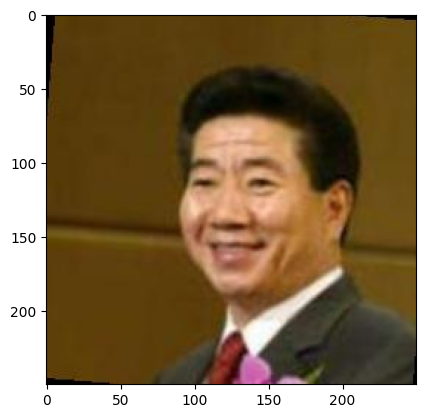

In [45]:
model = AE()
for x,y in dataloader:
    z = x[0].permute(1, 2, 0)
    # print(z.shape)
    # print(y)
    plt.imshow(z)
    encoder_output=model.encoder(x)
    decoder_output=model.decoder(encoder_output)
    print(encoder_output.data.shape)
    print(decoder_output.data.shape)
    # plt.imshow(encoder_output)

    break

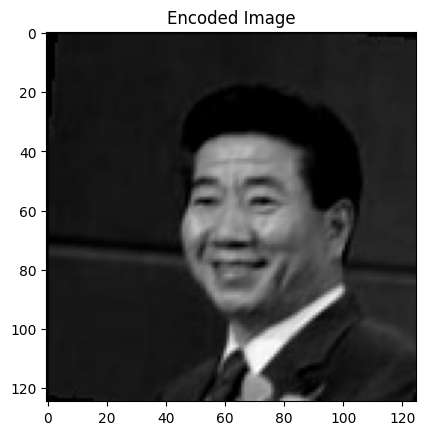

In [46]:
encoder_output=encoder_output[0].detach().cpu().numpy()
# plt.imshow(encoder_output.transpose(1,2,0))
# plt.imshow(encoder_output[0].reshape((1, 2)))
# plt.imshow(encoder_output.transpose(1,2,0), cmap='viridis')  # Use 'viridis' or another colormap
plt.imshow(encoder_output.transpose(1,2,0)[:,:,0], cmap='gray')  # Use 'viridis' or another colormap
plt.title('Encoded Image')
plt.show()

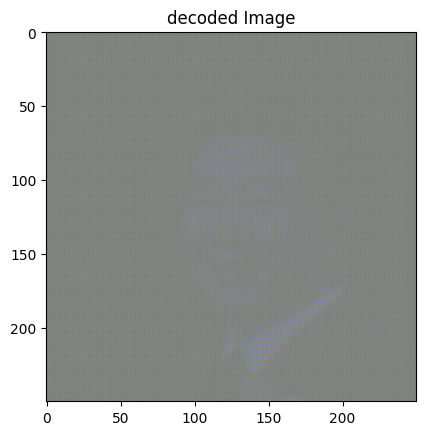

In [47]:
# plt.imshow(decoder_output)
decoder_output=decoder_output[0].detach().numpy()
# plt.imshow(encoder_output.transpose(1,2,0))
# plt.imshow(encoder_output[0].reshape((1, 2)))
plt.imshow(decoder_output.transpose(1,2,0), cmap='viridis')  # Use 'viridis' or another colormap
plt.title('decoded Image')
plt.show()

##  Step 5
Print total number of parameters in the model, explain what loss function you should use, create an optimizer for training

In [48]:
total_params = sum(p.numel() for p in model.parameters())
print(f"Total number of parameters: {total_params}")

Total number of parameters: 1763


In [49]:
import torch.optim as optim
optim = optim.Adam(model.parameters(), lr=0.001)

In [50]:
loss_function =nn.MSELoss()

##  Step 6
Write a training loop and start trainng the model for several epochs. Report the loss value at the end of each epoch and monitor it. If your loss is not decreasing what do you have to do to troubleshoot it ?

In [51]:
num_epochs=10
for epoch in range(num_epochs):
    model.train()  # Set the model to training mode
    total_loss = 0.0

    for x, _ in dataloader:
        # Forward pass
        outputs = model.forward(x)
        loss = loss_function(outputs, x)  # Assuming inputs are the target (reconstruction)

        # Backward pass and optimization
        optim.zero_grad()
        # loss.backward()
        optim.step()

        total_loss += loss.item()
        break

    # Print average loss at the end of each epoch
    average_loss = total_loss / len(dataloader)
    print(f"Epoch [{epoch + 1}/{num_epochs}], Loss: {average_loss}")

Epoch [1/10], Loss: 0.0002456522470223155
Epoch [2/10], Loss: 0.0002309136668553099
Epoch [3/10], Loss: 0.00023600855023388703
Epoch [4/10], Loss: 0.00024445554700450623
Epoch [5/10], Loss: 0.00025590358005053753
Epoch [6/10], Loss: 0.00024860321683584205
Epoch [7/10], Loss: 0.00023861621744966738
Epoch [8/10], Loss: 0.0002356185105399809
Epoch [9/10], Loss: 0.00024394768375705407
Epoch [10/10], Loss: 0.0002325239460825344


##  Step 7

Take a random image from the dataset and plot it against the reconstructed (encoded + decoded) image.

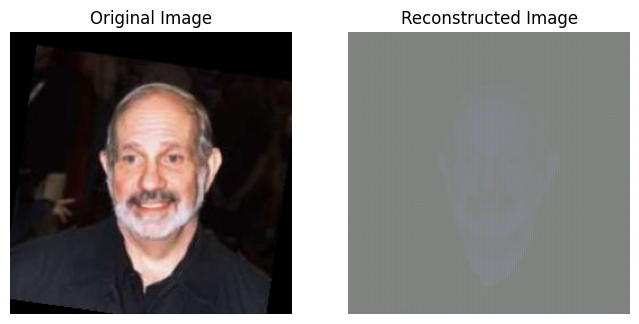

In [52]:
# for x,y in dataloader:
#     model_output=model.forward(x)
#     # encoder_output=model.encoder(x)
#     # encoder_output+=noise_level * torch.randn_like(encoder_output)
#     # decoder_output=model.decoder(encoder_output)
#     # print(encoder_output.data.shape)
#     # print(decoder_output.data.shape)
#     # plt.imshow(encoder_output)

#     break
fig, axes = plt.subplots(1, 2, figsize=(8, 4))

# Original Image
axes[0].imshow(x[0].permute(1, 2, 0))  # Assuming input_image has shape (batch_size, channels, height, width)
axes[0].set_title('Original Image')
axes[0].axis('off')

# Reconstructed Image
axes[1].imshow(outputs[0].detach().cpu().numpy().transpose(1, 2, 0))
axes[1].set_title('Reconstructed Image')
axes[1].axis('off')

plt.show()

##  Step 8

In step 7, add a small normaly distrubuted noise to the latent (hidden) representation of the input image and then decode it again. How is adding noise affecting the decoded image ?

torch.Size([250, 250, 3])
torch.Size([32, 32, 125, 125])
torch.Size([32, 3, 250, 250])


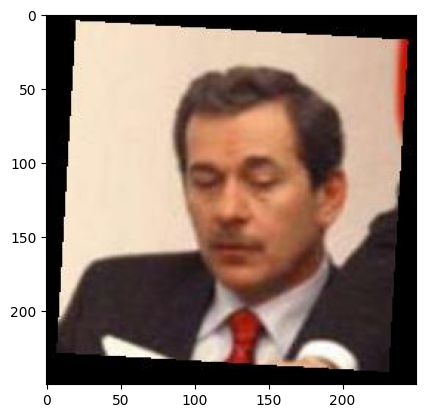

In [53]:
for x,y in dataloader:
    noise_level=0.1
    z = x[0].permute(1, 2, 0)
    print(z.shape)
    # print(y)
    plt.imshow(z)
    encoder_output=model.encoder(x)
    encoder_output+=noise_level * torch.randn_like(encoder_output)
    decoder_output=model.decoder(encoder_output)
    print(encoder_output.data.shape)
    print(decoder_output.data.shape)
    # plt.imshow(encoder_output)

    break

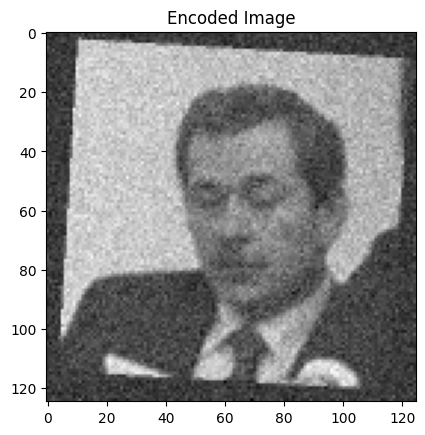

In [54]:
encoder_output=encoder_output[0].detach().cpu().numpy()
# plt.imshow(encoder_output.transpose(1,2,0))
# plt.imshow(encoder_output[0].reshape((1, 2)))
# plt.imshow(encoder_output.transpose(1,2,0), cmap='viridis')  # Use 'viridis' or another colormap
plt.imshow(encoder_output.transpose(1,2,0)[:,:,0], cmap='gray')  # Use 'viridis' or another colormap
plt.title('Encoded Image')
plt.show()



*   By adding noise to the latent representation during training, we see that the encoder image had a lot more static and this is generally done to learn a more robust and generalized representation, which often leads to improved performance on denoising tasks.



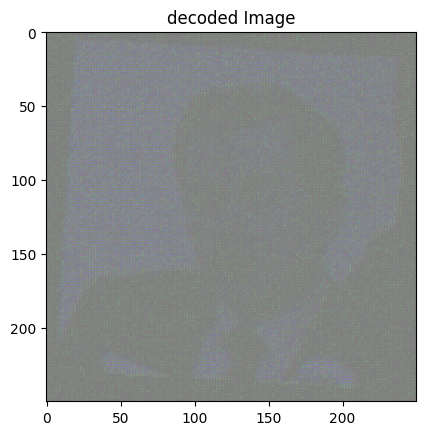

In [55]:
# plt.imshow(decoder_output)
decoder_output=decoder_output[0].detach().numpy()
# plt.imshow(encoder_output.transpose(1,2,0))
# plt.imshow(encoder_output[0].reshape((1, 2)))
plt.imshow(decoder_output.transpose(1,2,0), cmap='gray')  # Use 'viridis' or another colormap
plt.title('decoded Image')
plt.show()